In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
from EMAN2 import *
from sklearn.decomposition import PCA
from sklearn import cluster,mixture
plt.gray();

<Figure size 432x288 with 0 Axes>

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='0' 
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]='true' 
import tensorflow as tf

In [3]:
## in theory float16 also works but do not try it yet...
floattype=np.float32

In [4]:
## define a few core functions first

## project a list of points (B x N x 3) using a list of angles (B x 5)
## return 2D points
def xf2pts(pts, ang):

    azp=-ang[:,0]
    altp=ang[:,1]
    phip=-ang[:,2]

    matrix=tf.stack([(tf.cos(phip)*tf.cos(azp) - tf.cos(altp)*tf.sin(azp)*tf.sin(phip)),
    (tf.cos(phip)*tf.sin(azp) + tf.cos(altp)*tf.cos(azp)*tf.sin(phip)),
    (tf.sin(altp)*tf.sin(phip)),

    (-tf.sin(phip)*tf.cos(azp) - tf.cos(altp)*tf.sin(azp)*tf.cos(phip)),
    (-tf.sin(phip)*tf.sin(azp) + tf.cos(altp)*tf.cos(azp)*tf.cos(phip)),
    (tf.sin(altp)*tf.cos(phip)),

    (tf.sin(altp)*tf.sin(azp)),
    (-tf.sin(altp)*tf.cos(azp)),
    tf.cos(altp)], 0)

    matrix=tf.transpose(matrix)
    matrix=tf.reshape(matrix, shape=[-1, 3,3]) #### Here we get a batch_size x 3 x 3 matrix

    #### transform Gaussian positions
    if len(pts.shape)>2:
        pts_rot=tf.tensordot(pts, matrix, [[2],[2]])
        pts_rot=tf.transpose(pts_rot, (0,2,1,3))#, (-1, pts.shape[1],3))
        e=tf.eye(pts.shape[0], dtype=bool)#.flatten()
        pts_rot=pts_rot[e]
        
    else:
        pts_rot=tf.tensordot(pts, matrix, [[1],[2]])
        pts_rot=tf.transpose(pts_rot, [1,0,2])
    tx=ang[:,3][:,None]
    ty=ang[:,4][:,None]
    pts_rot_trans=tf.stack([(pts_rot[:,:,0]+tx), 
                               (-pts_rot[:,:,1])+ty
                               ], 2)
    
    pts_rot_trans*=sz
    pts_rot_trans+=sz/2
    return pts_rot_trans


#### make 2D projections in Fourier space
@tf.function
def pts2img(pts0, ang, lp=.1, sym="c1"):
    bsz=ang.shape[0]

    imgs_real=tf.zeros((bsz, sz,sz//2+1), dtype=floattype)
    imgs_imag=tf.zeros((bsz, sz,sz//2+1), dtype=floattype)

    #pts=pts0
    for pts in [pts0]:#[:,:1001,:], pts0[:,1001:,:]]:
        ni=pts.shape[1]

        pts=tf.reshape(pts, (-1, pts.shape[-1]))
        bamp=tf.reshape(pts[:, 3], (bsz,-1))
        bsigma=tf.reshape(pts[:, 4], (bsz,-1))
        multmodel=True

        p=tf.reshape(pts[:,:3], (bsz, ni, -1))

        bpos=xf2pts(p,ang)
        bposft=bpos*np.pi*2
        bposft=bposft[:, :, :, None, None]

        cpxang=idxft[0]*bposft[:,:,0] + idxft[1]*bposft[:,:,1]
        bamp0=tf.nn.relu(bamp[:, :,None, None])
        bsigma0=tf.nn.relu(bsigma[:,:,None, None])

        amp=tf.exp(-rrft*lp*bsigma0)*bamp0
        pgauss_real=tf.cos(cpxang)*amp
        pgauss_imag=-tf.sin(cpxang)*amp

        imgs_real+=tf.reduce_sum(pgauss_real, axis=1)
        imgs_imag+=tf.reduce_sum(pgauss_imag, axis=1)

    return (imgs_real, imgs_imag)

#### compute particle-projection FRC 
@tf.function
def calc_frc(data_cpx, imgs_cpx, return_curve=False):
    mreal, mimag=imgs_cpx
    dreal, dimag=data_cpx
    #### normalization per ring
    nrm_img=mreal**2+mimag**2
    nrm_data=dreal**2+dimag**2

    nrm0=tf.tensordot(nrm_img, rings, [[1,2],[0,1]])
    nrm1=tf.tensordot(nrm_data, rings, [[1,2],[0,1]])
    
    nrm=tf.sqrt(nrm0)*tf.sqrt(nrm1)
    nrm=tf.maximum(nrm, 1e-4) #### so we do not divide by 0
        
    #### average FRC per batch
    ccc=mreal*dreal+mimag*dimag
    frc=tf.tensordot(ccc, rings, [[1,2],[0,1]])/nrm
    
    if return_curve:
        return frc
    else:
        #### min/max resolution considered
#         fq= np.logical_and(freq>1./freq_bound[0], freq<1./freq_bound[1]).astype(floattype)
#         frcval=tf.reduce_sum(frc*fq[:sz//2], axis=1)/np.sum(fq)
#         frcval=tf.reduce_sum(frc*fq[:sz//2], axis=1)/np.sum(fq)
        frcval=tf.reduce_mean(frc[:, 4:], axis=1)
        return frcval

In [5]:
## load particles

fname="gmm_02/ptcls_small_all.hdf"
projs=EMData.read_images(fname)
apix=projs[0]["apix_x"]

hdrs=[p.get_attr_dict() for p in projs]
nsample=len(projs)


if fname.endswith(".lst"):
    lst=LSXFile(fname, True)
    xfs=[]
    for i in range(lst.n):
        l=lst.read(i)
        xfs.append(eval(l[2]))
else:
    xfs=[p["xform.projection"].get_params("eman") for p in hdrs]
    
# xfs=[p["xform.projection"].get_params("eman") for p in projs]
projs=np.array([p.numpy().copy() for p in projs], dtype=floattype)/1e3
data_cpx=np.fft.rfft2(projs)
data_cpx=(data_cpx.real.astype(floattype), data_cpx.imag.astype(floattype))
xfsnp=np.array([[x["az"],x["alt"],x["phi"], x["tx"], x["ty"]] for x in xfs], dtype=floattype)
xfsnp[:,:3]=xfsnp[:,:3]*np.pi/180.
xfsnp[:,3:]/=projs.shape[-1]
print(data_cpx[0].shape)

(124899, 128, 65)


In [6]:
## set up fourier indices for image generation

sym="c1"
sz=data_cpx[0].shape[1]
idx=np.indices((sz,sz))-sz//2
idx=np.fft.ifftshift(idx)
idx=idx[:,:,:sz//2+1]

freq=np.fft.fftfreq(sz, apix)[:sz//2]

ci=idx[0,0]
cj=idx[1,:,0]
cj[cj<0]+=1
clipid=[abs(ci), abs(cj)]


def get_clip(datacpx, newsz):
    if (datacpx[0].shape[1])<=newsz:
        return [tf.constant(d) for d in datacpx]
    s=newsz//2
    dc=[tf.boolean_mask(d,clipid[1]<s, axis=1) for d in datacpx]
    dc=[tf.boolean_mask(d,clipid[0]<s+1, axis=2) for d in dc]
    return dc

def get_indices_boxsz(sz):
    idx=np.indices((sz,sz))-sz//2
    idx=np.fft.ifftshift(idx)
    idx=idx[:,:,:sz//2+1]
    idxft=(idx/sz).astype(floattype)[:, None, :,:]
    rrft=np.sqrt(np.sum(idx**2, axis=0)).astype(floattype)## batch, npts, x-y


    rr=np.round(np.sqrt(np.sum(idx**2, axis=0))).astype(int)
    rings=np.zeros((sz,sz//2+1,sz//2), dtype=floattype) #### Fourier rings
    for i in range(sz//2):
        rings[:,:,i]=(rr==i)
    
    return idxft, rrft, rings

## this is the size of particles to use
## should work up to 128 on RTX2080
sz=64
idxft, rrft, rings=get_indices_boxsz(sz)

In [9]:
## load the model from e2gmm_refine.py

pts=np.loadtxt("gmm_02/model_01.txt")
print(pts.shape)
npt=len(pts)
bsz=16
pall=np.zeros((npt, 5), dtype=floattype)
pall[:,3:]=1
layers=[
    tf.keras.layers.Dense(512,input_shape=(1,2),activation="relu",
                         bias_initializer=tf.random_normal_initializer(0,.01)),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(npt*5, kernel_initializer=tf.random_normal_initializer(.0,.1),
                         bias_initializer=tf.constant_initializer(pall)),
    tf.keras.layers.Reshape((npt,5))
]
gen_model=tf.keras.Sequential(layers)
# pout=gen_model(np.zeros((bsz,1,2), dtype=floattype))
pout=gen_model(0*np.random.randn(bsz,1,2).astype(floattype))
print(pout.shape)
imgs_real, imgs_imag=pts2img(pout[:bsz], xfsnp[:bsz], sym=sym)

imgs_cpx=imgs_real.numpy().astype(floattype)+1j*imgs_imag.numpy().astype(floattype)
imgs_out=np.fft.irfft2(imgs_cpx)
print(imgs_out.shape)

ii=1
dcpx=list(d[:bsz].real.astype(floattype) for d in data_cpx)
dcpx=get_clip(dcpx, sz)
frc=calc_frc(dcpx, (imgs_real, imgs_imag), True)
fval=np.mean(frc, axis=1)

print(np.max(imgs_real), np.max(imgs_out))
print(np.min(fval), np.max(fval), np.mean(frc))
# print(pout)

(3082, 5)
(16, 3082, 5)
(16, 64, 64)
3082.3582 343.93726
-0.040219843 0.098614514 0.018754182


In [10]:
## pre-train the generator

conf=tf.zeros((1,1,2), dtype=floattype)
opt=tf.keras.optimizers.Adam(learning_rate=1e-4) 
gen_model.compile(optimizer=opt, loss=tf.losses.MeanAbsoluteError())
for i in range(500):
    gen_model.train_on_batch(conf, pts)
    
print(gen_model.train_on_batch(conf, pts))

opt=tf.keras.optimizers.Adam(learning_rate=1e-6) 
gen_model.compile(optimizer=opt, loss=tf.losses.MeanAbsoluteError())
for i in range(100):
    gen_model.train_on_batch(conf, pts)
print(gen_model.train_on_batch(conf, pts))

0.00026436572
4.937477e-06


0.1755045
tf.Tensor(
[0.25377846 0.14551851 0.03609546 0.20981063 0.20473024 0.2661507
 0.2811016  0.01987641 0.24398644 0.02603851 0.08521373 0.3363065
 0.3475514  0.07924699 0.2115031  0.06116321], shape=(16,), dtype=float32)
tf.Tensor(0.4146415, shape=(), dtype=float32)


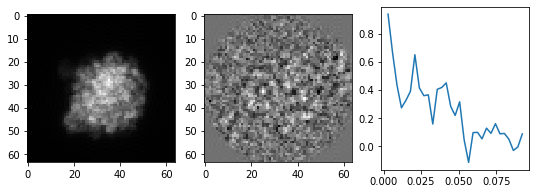

In [11]:
## make sure everything is working correctly

conf=0*np.random.randn(bsz,1,2).astype(floattype)
# conf=tf.reshape(conf, (bsz,1,2)).numpy()
pout=gen_model(conf)
po=pout.numpy()
imgs_real, imgs_imag=pts2img(po,xfsnp[:bsz], lp=.05, sym=sym)

imgs_cpx=imgs_real.numpy().astype(floattype)+1j*imgs_imag.numpy().astype(floattype)
imgs_out=np.fft.irfft2(imgs_cpx)

ii=3
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(imgs_out[ii])
plt.subplot(1,3,2)
# print(xfsnp[ii])

dcpx=(data_cpx[0][:bsz], data_cpx[1][:bsz])
dcpx=get_clip(dcpx, sz)

# dcpx_out=np.fft.irfft2(dcpx[0].numpy()+1j*dcpx[1].numpy())
dcpx_out=np.fft.irfft2(dcpx[0].numpy()+1j*dcpx[1].numpy())
plt.imshow(dcpx_out[ii])

# print(dcpx[0].shape, imgs_real.shape)
frc=calc_frc(dcpx, (imgs_real, imgs_imag), True)
plt.subplot(1,3,3)
plt.plot(freq[1:sz//2],frc[ii][1:])
fval=calc_frc(dcpx, (imgs_real, imgs_imag))
print(np.mean(fval))
print(fval)
print(frc[ii][sz//8])



In [12]:
## compute the gradient with respect to neutral model for each particle
## set up

conf=np.zeros((1,1,2), dtype=floattype)
pout=gen_model(conf)
pout00=pout[0].numpy()

dcpx=get_clip(data_cpx, sz)
nsample=len(projs)
bsz=8
trainset=tf.data.Dataset.from_tensor_slices((dcpx[0], dcpx[1], xfsnp))
trainset=trainset.batch(bsz)
nbatch=nsample//bsz


In [17]:
## acutal computing gradient

allgrds=[]
allscr=[]
n=0
for pjr,pji,xf in trainset:

    pj_cpx=(pjr, pji) ## particle image
    
    with tf.GradientTape() as gt:
        
        pt=tf.Variable(tf.repeat(pout, xf.shape[0], axis=0)) ## neutral model in points
        imgs_cpx=pts2img(pt, xf, sym=sym) ## model projection image
        fval=calc_frc(pj_cpx, imgs_cpx) ## frc values        
        loss=-tf.reduce_mean(fval) 

    grad=gt.gradient(loss, pt)
    allgrds.append(grad.numpy().copy())
    allscr.append(fval.numpy().copy())
    n+=len(allscr[-1])
    sys.stdout.write("\r {}/{}        ".format(n, len(dcpx[0])))
    sys.stdout.flush()
    
    
allgrds=np.concatenate(allgrds, axis=0)
allscr=np.concatenate(allscr, axis=0)
allgrds=allgrds/np.std(allgrds)
print(allgrds.shape)  

 124899/124899        (124899, 3082, 5)


In [19]:
## save everything first

ag=from_numpy(allgrds)
ag.write_image("gmm_02/allgrads.hdf")
np.savetxt('gmm_02/allscr.txt', allscr)

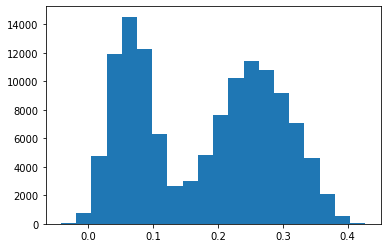

In [20]:
## eliminate the bad particles

plt.hist(allscr,20);

In [22]:
## only use particles above a threshold

idx=allscr>.15
n=np.sum(idx)//bsz*bsz
scrthr=-np.sort(-allscr)[n]
idx=allscr>scrthr
print(np.sum(idx), np.mean(allscr[idx]))

71136 0.26213074


In [11]:
## load gradient from saved file

loading=False
if loading:
    allgrds=EMData("gmm_02/allgrads.hdf")
    allgrds=allgrds.numpy().copy()
    print(allgrds.shape)

(6000, 3081, 5)


In [23]:
## initialize encoder

l2=tf.keras.regularizers.l2(1e-3)
kinit=tf.keras.initializers.RandomNormal(0,1e-2)

layers=[
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=l2),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=l2),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=l2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, kernel_regularizer=l2, kernel_initializer=kinit),
]
encode_model=tf.keras.Sequential(layers)

mid=encode_model(allgrds[:500])
# dis_model.load_weights("gmm_01/dismodel.h5")

print(mid.shape)

(500, 4)


(500, 3082)


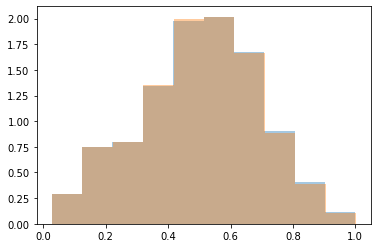

In [32]:
## initialize decoder
## make sure the output of the decoder matches the neutral model when the input is 0

l2=tf.keras.regularizers.l2(1e-3)
kinit=tf.keras.initializers.RandomNormal(0,1e-4)

layers=[
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=l2),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=l2),
    tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=l2),
#     tf.keras.layers.Dropout(.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(npt, activation="sigmoid", kernel_regularizer=l2),
    tf.keras.layers.Reshape((npt,)),
]
decode_model=tf.keras.Sequential(layers)
out=decode_model(mid)
p=pout00[:,3].copy()
p=np.clip(p, 1e-6, 1-1e-6)
p=-np.log(1./p-1)
decode_model.layers[-2].bias.assign(p)
out=decode_model(mid)
print(out.shape)
plt.hist(out.numpy().flatten(),density=True, alpha=.4);
plt.hist(pout00[:,3],density=True, alpha=.4);

In [310]:
## set up training

bsz=8
idx=allscr>scrthr

# trainset=tf.data.Dataset.from_tensor_slices((allgrds, dcpx[0], dcpx[1], xfsnp))
trainset=tf.data.Dataset.from_tensor_slices((allgrds[idx], dcpx[0][idx], dcpx[1][idx], xfsnp[idx]))
trainset=trainset.batch(bsz)

opt=tf.keras.optimizers.Adam(learning_rate=1e-4) 
wts=encode_model.trainable_variables
wts+=decode_model.trainable_variables
nbatch=0
for t in trainset:
    nbatch+=1

In [217]:
%%time
## manifold embedding training
## here only look at amplitude first

for itr in range(10):
        
    cost=[]
    for grd,pjr,pji,xf in trainset:
        pj_cpx=(pjr, pji) ## particle image
        
        with tf.GradientTape() as gt:
            conf=encode_model(grd, training=True) ## encode conformation vector
            conf=.1*tf.random.normal(conf.shape)+conf ## kind of variational autoencoder to seperate classes
            
            pout=tf.zeros((xf.shape[0],pout00.shape[0], 5))+pout00 ## neutral model
            
            c=decode_model(conf, training=True) ## decoded model, amplitude only
            pout=tf.concat([pout[:,:,:3], c[:,:,None], pout[:,:,4:]], axis=2) ## use position and sigma from neutral model
            
            imgs_cpx=pts2img(pout, xf, sym=sym) ## projection image
            fval=calc_frc(pj_cpx, imgs_cpx) ## frc
            loss=-tf.reduce_mean(fval)
        
        cost.append(loss)
        grad=gt.gradient(loss, wts)
        opt.apply_gradients(zip(grad, wts))
        
        sys.stdout.write("\r {}/{}\t{:.3f}         ".format(len(cost), nbatch, loss))
        sys.stdout.flush()
    sys.stdout.write("\r")
    
    print("iter {}, loss : {:.4f},".format(itr, np.mean(cost)))

iter 0, loss : -0.3394,  
CPU times: user 6.74 s, sys: 2.57 s, total: 9.31 s
Wall time: 7.71 s


In [87]:
decode_model.save_weights("gmm_02/model_decode.h5")
encode_model.save_weights("gmm_02/model_encode.h5")

In [313]:
## compute conformation for all particles
ag=allgrds[idx]
mid=[]
b=1000
for i in range(len(ag)//b+1):
    a=ag[i*b:(i+1)*b]
    m=encode_model(a)
    mid.append(m.numpy().copy())
    
mid=np.concatenate(mid, axis=0)
print(mid.shape)

(71136, 4)


10


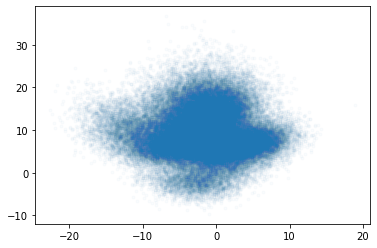

In [314]:
## exclude outliers

ii=np.where(idx)[0]
d=np.linalg.norm(mid, axis=1)
idxnew=idx.copy()
ix=d<np.std(d)*8
print(np.sum(1-ix))
idxnew[ii[np.logical_not(ix)]]=False
plt.plot(mid[ix,0], mid[ix,1],'.', alpha=.02)

In [316]:
## save conformation
sv=np.hstack([np.where(idxnew)[0][:,None], mid[ix]])
print(sv.shape)
np.savetxt("gmm_02/mid_01.txt", sv)

(71126, 5)


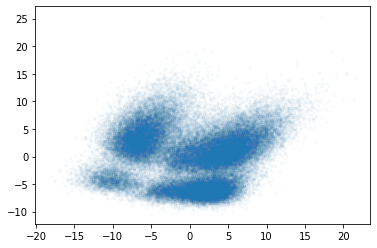

In [10]:
## PCA to rearrange middle layer output

md=mid[ix]
pca=PCA(4)
p2=pca.fit_transform(md)

plt.scatter(p2[:,0], p2[:,1],s=5,  alpha=.02)


-18 [ 19268.  41807.  13426. ... 117239.  95160.  34273.]
-12 [ 19268.  13426.  83629. ...  27001.  23702. 124251.]
-6 [ 79833.  94729. 116684. ... 115244.  46826. 108599.]
0 [123240. 120029.  44396. ...  79456. 103151. 118531.]
6 [ 49700.  22270. 113962. ...  42270.  42824.  76588.]
12 [37343. 42387. 80056. ...  5240. 95550.   343.]
18 [20323. 26475. 55642. ... 94119.  3670. 46675.]


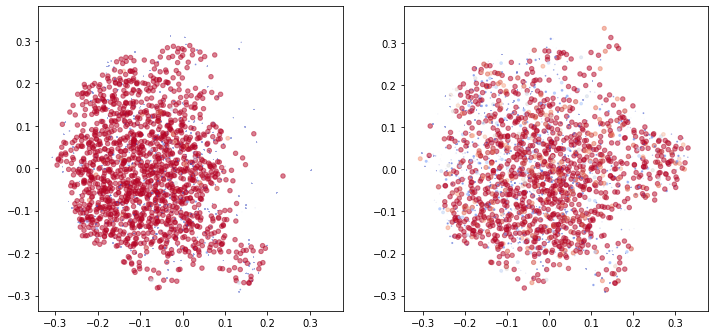

In [90]:
## look at the gaussian model along the first eigen vector

rg=np.arange(-18, 19, 6)
plt.figure(figsize=(12,6))
for j,ir in enumerate(rg):
    pos=np.zeros(4, dtype=floattype)
    pos[1]=ir
    d=np.linalg.norm(p2-pos, axis=1)
    ix=np.argsort(d)[:2000]
    ix=sv[ix, 0]
    
    print(ir, ix)
    pos=pca.inverse_transform(pos)
    pc=decode_model(pos[None,:])[0]
    
    p=pout00
    if j==0 or j==len(rg)-1:
        plt.subplot(1,2,1+(j>0))
        plt.scatter(p[:,0], p[:,1],s=pc*20, c=pc, cmap='coolwarm', alpha=.5)
        plt.axis("square");
    

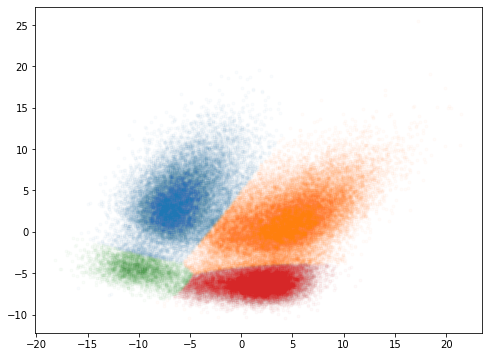

In [13]:
### cluster and write subset list
clust = mixture.GaussianMixture(4)
lbs=clust.fit_predict(p2[:,:2])

fname="gmm_02/ptcls_small_all.hdf"
onames=[]
plt.figure(figsize=(8,6))

for j,l in enumerate(np.unique(lbs)):
    ii=(lbs==l)
    plt.plot(p2[ii,0], p2[ii,1],'.', alpha=.02, label=l)
    idx=sv[ii,0].astype(int)
    onm="gmm_02/ptcl_cls_{:02d}.lst".format(j+0)
    if os.path.isfile(onm):
        os.remove(onm)
    lout=LSXFile(onm, False)
    for i in idx:
        lout.write(-1, i, fname)
        
    lout=None
    onames.append(onm)
        
# plt.legend()
        

In [ ]:
## make 3d maps
for o in onames:
    t=o.replace("ptcl", "threed")[:-3]+"hdf"
    print(o,t)
    cmd="e2make3dpar.py --input {} --output {} --pad 256 --mode trilinear --keep 1 --setsf sf_lp.txt --threads 12".format(o,t)
    launch_childprocess(cmd)

#### now look at conformational changes

In [147]:
## compute gaussian model for every particle

pts=[]
b=1000
mm=mid[ix]
for i in range(len(mm)//b+1):
    a=mm[i*b:(i+1)*b]
    m=decode_model(a)
    pts.append(m.numpy().copy())
    
pts=np.concatenate(pts, axis=0)
print(pts.shape)

(71126, 3082)


506


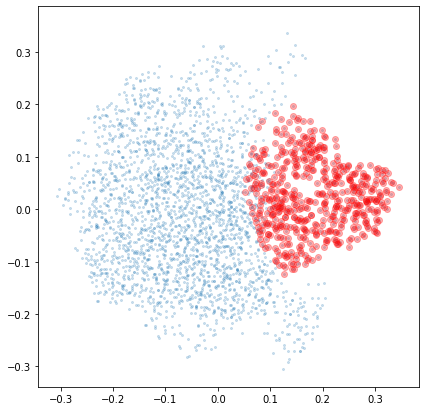

In [344]:
## focus on this domain

p=pout00
plt.figure(figsize=(7,7))
plt.scatter(p[:,0], p[:,1],s=4, alpha=.2)
d=np.linalg.norm(p[:,:3]-[.3,0.05,0.1], axis=1)
# d=np.linalg.norm(p[:,:3]-[.15,-.25,-.1], axis=1)
imsk=d<.25
print(np.sum(imsk))
# plt.scatter(p[imsk,0], p[imsk,1],c=d[imsk], cmap='coolwarm', alpha=.3)
plt.scatter(p[imsk,0], p[imsk,1],c='r', alpha=.3)
plt.axis("square");

45686


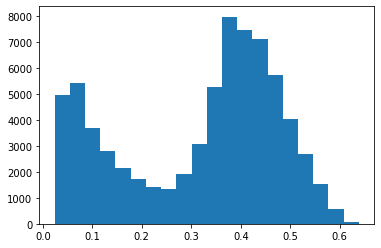

In [308]:
## select particles with the domain

c=np.mean(pts[:, imsk], axis=1)
plt.hist(c,20);
ic=c>.3
print(np.sum(ic))


i=sv[ic,0].astype(int)
idx=np.zeros(len(xfsnp), dtype=bool)
idx[i]=True

In [304]:
## set up another pair of encoder-decoder
## this time for domain motion

l2=tf.keras.regularizers.l2(1e-3)
kinit=tf.keras.initializers.RandomNormal(0,1e-2)

layers=[
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=l2),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=l2),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=l2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, kernel_regularizer=l2, kernel_initializer=kinit),
]
encode_model1=tf.keras.Sequential(layers)

mid=encode_model1(allgrds[:500])
# dis_model.load_weights("gmm_01/dismodel.save")

# print(conf)
print(mid.shape)

(500, 4)


(500, 3082, 3)


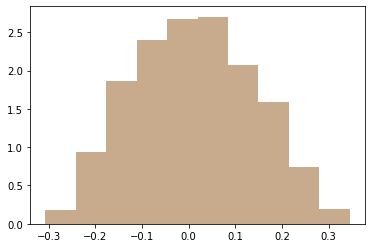

In [305]:
l2=tf.keras.regularizers.l2(1e-3)
kinit=tf.keras.initializers.RandomNormal(0,1e-4)

layers=[
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=l2),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=l2),
    tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=l2),
#     tf.keras.layers.Dropout(.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(npt*3, activation="sigmoid", kernel_regularizer=l2, kernel_initializer=kinit),
    tf.keras.layers.Reshape((npt,3)),
]
decode_model1=tf.keras.Sequential(layers)
out=decode_model1(mid)
p=pout00[:,:3].copy()+.5
p=np.clip(p, 1e-6, 1-1e-6)
p=-np.log(1./p-1)
decode_model1.layers[-2].bias.assign(p.flatten())
out=decode_model1(mid)-.5
print(out.shape)
plt.hist(out.numpy().flatten(),density=True, alpha=.4);
plt.hist(pout00[:,:3].flatten(),density=True, alpha=.4);

In [318]:
## set up training

bsz=8

trainset=tf.data.Dataset.from_tensor_slices((allgrds[idx], dcpx[0][idx], dcpx[1][idx], xfsnp[idx]))
trainset=trainset.batch(bsz)

opt=tf.keras.optimizers.Adam(learning_rate=1e-4) 
wts=encode_model1.trainable_variables
wts+=decode_model1.trainable_variables
nbatch=0
for t in trainset:
    nbatch+=1

In [327]:
%%time
for itr in range(20):
        
    cost=[]
    for grd,pjr,pji,xf in trainset:
        pj_cpx=(pjr, pji)
        with tf.GradientTape() as gt:
            
            conf=encode_model1(grd, training=True) ## conformation for motion
            conf=.1*tf.random.normal(conf.shape)+conf
            p0=tf.zeros((xf.shape[0],pout00.shape[0], 5))+pout00 ## neutral model
            c=decode_model1(conf, training=True)-.5 
            c=c*imsk[None,:,None]+p0[:,:,:3]*(1-imsk[None,:,None]) ## mask out only domain of interest
            
            c0=encode_model(grd) ## get amplitude from previous model
            c0=decode_model(c0)
            pout=tf.concat([c,c0[:,:,None], p0[:,:,4:]], axis=2)
        
            imgs_cpx=pts2img(pout, xf, sym=sym)
            fval=calc_frc(pj_cpx, imgs_cpx)
            loss=-tf.reduce_mean(fval)#+reg
        
        cost.append(loss)
        grad=gt.gradient(loss, wts)
        opt.apply_gradients(zip(grad, wts))

        sys.stdout.write("\r {}/{}\t{:.3f}         ".format(len(cost), nbatch, loss))
        sys.stdout.flush()
    sys.stdout.write("\r")
    
    print("iter {}, loss : {:.4f},".format(itr, np.mean(cost)))

iter 0, loss : -0.2681,   
iter 1, loss : -0.2685,   
iter 2, loss : -0.2689,   
iter 3, loss : -0.2693,   
iter 4, loss : -0.2696,   
iter 5, loss : -0.2700,   
iter 6, loss : -0.2703,   
iter 7, loss : -0.2706,   
iter 8, loss : -0.2708,   
iter 9, loss : -0.2711,   
iter 10, loss : -0.2714,  
iter 11, loss : -0.2716,  
iter 12, loss : -0.2718,  
iter 13, loss : -0.2721,  
iter 14, loss : -0.2723,  
iter 15, loss : -0.2725,  
iter 16, loss : -0.2728,  
iter 17, loss : -0.2730,  
iter 18, loss : -0.2732,  
iter 19, loss : -0.2734,  
CPU times: user 2h 38min 44s, sys: 10min 32s, total: 2h 49min 17s
Wall time: 3h 12min 41s


In [328]:
## conformation output
ag=allgrds[idx]
mid=[]
b=1000
for i in range(len(ag)//b+1):
    a=ag[i*b:(i+1)*b]
    m=encode_model1(a)
    mid.append(m.numpy().copy())
    
mid=np.concatenate(mid, axis=0)
print(mid.shape)

(45686, 4)


30


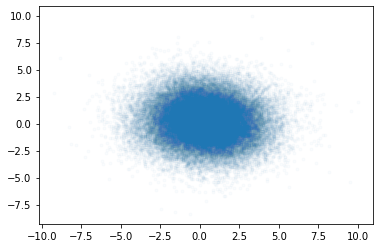

In [329]:
## remove outliers
ii=np.where(idx)[0]
d=np.linalg.norm(mid, axis=1)
idxnew=idx.copy()
ix=d<np.std(d)*8
print(np.sum(1-ix))
idxnew[ii[np.logical_not(ix)]]=False
plt.plot(mid[ix,0], mid[ix,1],'.', alpha=.02)

In [336]:
## save conformation
sv=np.hstack([np.where(idxnew)[0][:,None], mid[ix]])
print(sv.shape)
np.savetxt("gmm_02/mid_02.txt", sv)

(45656, 5)


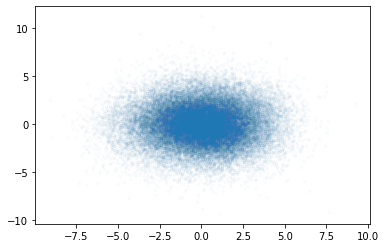

In [330]:
pca=PCA(4)
p2=pca.fit_transform(mid[ix])

plt.scatter(p2[:,0], p2[:,1],s=5,  alpha=.02)


(-0.4, 0.4)

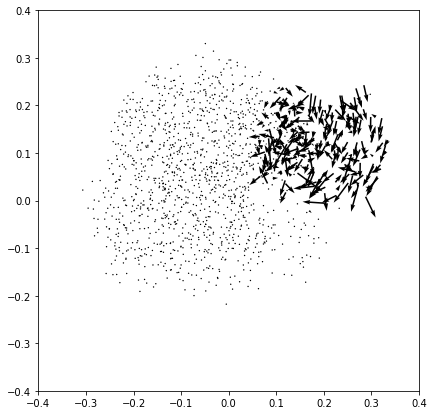

In [340]:
## visualize domain motion
cf=np.zeros((2,4), dtype=floattype)
cf[0,0]=-2
cf[1,0]=2
cf=pca.inverse_transform(cf).astype(floattype)
p=pout00.copy()
pc=decode_model1(cf)-.5
pc=pc[1]-pc[0]
# pc=np.linalg.norm(pc[:,:3], axis=1)
# print(pc)
plt.figure(figsize=(7,7))
# plt.scatter(p[:,0], p[:,2], s=5,alpha=.5)
plt.quiver(p[1::2,0], p[1::2,2], pc[1::2,0], pc[1::2,2],scale=.4, width=4e-3)
plt.axis("square")
plt.xlim(-.4, .4)
plt.ylim(-.4, .4)

In [345]:
decode_model1.save_weights("gmm_02/model_decode1.h5")
encode_model1.save_weights("gmm_02/model_encode1.h5")